In [39]:
# Note: version 0.14.8 is use in this notebook -
# pomegranate 1.0 forward uses pytorch backend and a different interface, see pomegranate.hmm.DenseHMM
pip install pomegranate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import itertools
import operator
from random import random
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import pomegranate
from pomegranate import HiddenMarkovModel, DiscreteDistribution, State
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

## Get data

In [ ]:
!wget -q -O chicago_streets.csv \
 https://data.cityofchicago.org/api/views/i6bp-fvbx/rows.csv?accessType=DOWNLOAD

In [42]:
streets_df = pd.read_csv("chicago_streets.csv")
streets_df.shape

(2582, 7)

In [43]:
streets_df.head()

,Full Street Name,Direction,Street,Suffix,Suffix Direction,Min Address,Max Address
0,E 100TH PL,E,100TH,PL,,1,1199
1,W 100TH PL,W,100TH,PL,,300,2629
2,E 100TH ST,E,100TH,ST,,1,4001
3,W 100TH ST,W,100TH,ST,,1,2799
4,E 101ST PL,E,101ST,PL,,1,699


In [44]:
streets_df[streets_df["Suffix Direction"].str.isalpha()].sample(5)

,Full Street Name,Direction,Street,Suffix,Suffix Direction,Min Address,Max Address
2307,W SHERMAN PARK N,W,SHERMAN PARK,,N,1216,1336
2361,W STEVENSON EXPY OB,W,STEVENSON,EXPY,OB,1,4832
1673,N LINCOLN PARK W,N,LINCOLN PARK,,W,1800,2399
845,S DAN RYAN EXPY IB,S,DAN RYAN,EXPY,IB,510,9599
1592,S LAKE PARK AVE W,S,LAKE PARK,AVE,W,5300,5399


## Create labeled dataset

In [45]:
streets_df.columns = [x.strip() for x in streets_df.columns]

vocab = {y for x in streets_df["Full Street Name"].str.split() for y in x}
vocab = sorted(list(vocab))
word2idx = {x: i for i, x in enumerate(vocab)}

fields = ["Direction", "Street", "Suffix", "Suffix Direction"]
field_names = {"Direction": "DIR", 
               "Street": "STR", 
               "Suffix": "SUF", 
               "Suffix Direction": "SD"}
def iob2_tag(span, tagname):
    if span >= 1:
        return [f"B-{tagname}"] + [f"I-{tagname}" for i in range(span-1)]
    return []

X = []
Y = []
for _, row in streets_df.iterrows():
    row = row.to_dict()
    X.append(np.array(list(itertools.chain.from_iterable([row[x].split() for x in fields]))))
    Y.append(list(itertools.chain.from_iterable([iob2_tag(len(row[x].split()), field_names[x]) for x in fields])))

In [46]:
X[0], Y[0]

(array(['E', '100TH', 'PL'], dtype='<U5'), ['B-DIR', 'B-STR', 'B-SUF'])

In [47]:
states = sorted(list({y for x in Y for y in x}))
num_states = len(states)
states

['B-DIR', 'B-SD', 'B-STR', 'B-SUF', 'I-STR']

## Train HMM using `pomegranate`

In [48]:
hmm = HiddenMarkovModel()
hmmstates = [State(DiscreteDistribution.from_samples(vocab), name=s) for s in states]
hmm.add_states(hmmstates)
for s1 in hmmstates:
    hmm.add_transition(hmm.start, s1, 1.0/len(hmmstates))
    for s2 in hmmstates + [hmm.end]:
        hmm.add_transition(s1, s2, 1.0/(len(hmmstates)+1))
hmm.bake()

In [49]:
# hmm.fit(sequences=X, labels=Y, algorithm="labeled")

# ^ Broken
# Implement manually
state_dict = {s: i for i, s in enumerate(states)}
start_counts = [0 for j in range(num_states)]
transition_counts = [[0 for j in range(num_states + 1)] 
                     for i in range(num_states)]

# Iterate through data collecting transition counts
for i, y in enumerate(Y):
    start_counts[state_dict[y[0]]] += 1
    for j, yy in enumerate(y):
        if j + 1 == len(y):
            transition_counts[state_dict[yy]][-1] += 1
        else:
            transition_counts[state_dict[yy]][state_dict[y[j+1]]] += 1

# Calculate emission probabilities for each state
for i, s in enumerate(hmmstates):
    assoc_vocab = [X[i][j] for i, y in enumerate(Y) for j, yy in enumerate(y) if yy == s.name]
    s.distribution = DiscreteDistribution.from_samples(assoc_vocab)

# Calculate transition probabilities for each state pair
for i, s in enumerate(hmmstates):
    hmm.add_transition(hmm.start, s, start_counts[i]/sum(start_counts))
    for j, ss in enumerate(hmmstates):
        hmm.add_transition(s, ss, transition_counts[i][j]/sum(transition_counts[i]))
    hmm.add_transition(s, hmm.end, transition_counts[i][-1]/sum(transition_counts[i]))
    
hmm.bake()

### Inspect states and transition probabilities

In [ ]:
hmm.states

In [51]:
def show_states(states):
    pd_data = []
    for s in states:
        if s.distribution:
            top_words = sorted(s.distribution.parameters[0].items(), 
                               key=operator.itemgetter(1), 
                               reverse=True)[:5]
            for w in top_words:
                pd_data.append({"state": s.name, "word": w[0], "prob": "{:0.4f}".format(w[1])})
        else:
            pd_data.append({"state": s.name, "word": "--", "prob": "--"})
    display(pd.DataFrame(pd_data, columns=["state", "word", "prob"]))

In [52]:
show_states(hmm.states)

,state,word,prob
0,B-DIR,W,0.3184
1,B-DIR,N,0.2734
2,B-DIR,S,0.2665
3,B-DIR,E,0.1418
4,B-SD,OB,0.2080
5,B-SD,IB,0.1840
6,B-SD,W,0.1280
7,B-SD,E,0.1200
8,B-SD,S,0.0960
9,B-STR,KENNEDY,0.0380


In [ ]:
plt.figure(figsize=(12,12))
hmm.plot()
plt.show()

In [54]:
def show_transitions(transitions, states):
    t_df = pd.DataFrame(transitions, columns=states)
    t_df["from_state"] = states
    t_df.set_index("from_state", inplace=True)
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(t_df, annot=True, fmt="0.2f")
    plt.xlabel("to_state")
    plt.show()

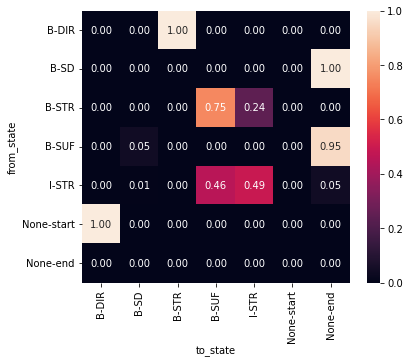

In [55]:
show_transitions(hmm.dense_transition_matrix(), [x.name for x in hmm.states])

### Sample random street names from model

In [26]:
for samp in hmm.sample(10):
    print(" ".join(list(samp)))

S KIMBERLY PL
E CHELTENHAM ST
S EISENHOWER AVE
W WALLER CREEK ER
W LEOTI AVE
N TAFT ST
N LONG ST IB
N HIGH ST
N OSCEOLA AVE
S CLINTON SACRAMENTO ST AVE


### Demonstrate forward and backward probabilities

In [27]:
test_street = ["N", "CLARK", "ST"]

In [28]:
def show_fb_matrix(fbm, states):
    t_df = pd.DataFrame(fbm, columns=states)
    t_df = t_df.T
    plt.figure()
    ax = sns.heatmap(t_df, annot=True, fmt="0.2f")
    plt.xlabel("state")
    plt.show()

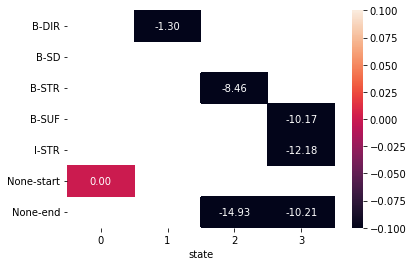

In [29]:
f_matrix = hmm.forward(test_street)
show_fb_matrix(f_matrix, [x.name for x in hmm.states])

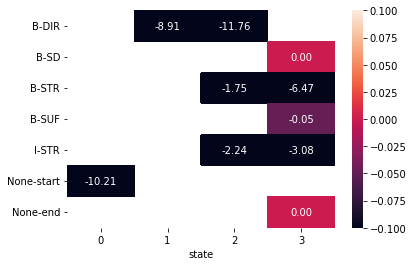

In [30]:
b_matrix = hmm.backward(test_street)
show_fb_matrix(b_matrix, [x.name for x in hmm.states])

In [31]:
logprob, state_seq = hmm.viterbi(test_street)
print("Viterbi tag sequence: ")
print(f"  {' '.join([x[1].name for x in state_seq])}")
print(f"  logprob = {logprob:0.2f}")

Viterbi tag sequence: 
  None-start B-DIR B-STR B-SUF None-end
  logprob = -10.22


## Train HMM unsupervised

In [32]:
## HMM_INIT = "uniform"
HMM_INIT = "random"

In [57]:
hmm = HiddenMarkovModel()
hmmstates = [State(DiscreteDistribution.from_samples(vocab), name=s) 
             for s in ["A", "B", "C", "D", "E"]]
hmm.add_states(hmmstates)

if HMM_INIT == "uniform":
    for s1 in hmmstates:
        hmm.add_transition(hmm.start, s1, 1.0/len(hmmstates))
        for s2 in hmmstates + [hmm.end]:
            hmm.add_transition(s1, s2, 1.0/(len(hmmstates)+1))
else:
    transition_matrix = np.random.random((len(hmmstates), len(hmmstates)+1))
    transition_matrix = (transition_matrix.T / transition_matrix.sum(axis=1)).T
    for i, s1 in enumerate(hmmstates):
        hmm.add_transition(hmm.start, s1, 1.0/len(hmmstates))
        for j, s2 in enumerate(hmmstates + [hmm.end]):
            hmm.add_transition(s1, s2, transition_matrix[i][j])

hmm.bake()

In [ ]:
hmm.fit(sequences=X, algorithm="baum-welch", max_iterations=20)

In [ ]:
plt.figure(figsize=(12,12))
hmm.plot()
plt.show()

In [59]:
for samp in hmm.sample(10):
    print(" ".join(list(samp)))

N MEDINA AVE
N LAKEFRONT ST
S LEAMINGTON RD
W VERMONT AVE
N ANTHON RYAN DR AVE
S GREEN ER
N KEWANEE SKYWAY HIGGINS DR PL
W INDEPENDENCE DR
N 79TH PARK 134TH DR
W MARINE PL


In [60]:
show_states(hmm.states)

,state,word,prob
0,A,KENNEDY,0.0356
1,A,AV,0.0319
2,A,DAN,0.0290
3,A,EISENHOWER,0.0208
4,A,LSD,0.0181
5,B,ST,0.3988
6,B,AVE,0.2739
7,B,DR,0.1043
8,B,PL,0.0769
9,B,BLVD,0.0335


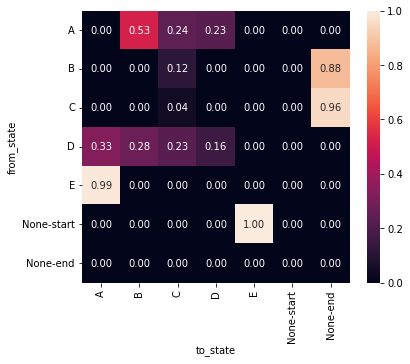

In [61]:
show_transitions(hmm.dense_transition_matrix(), [x.name for x in hmm.states])